In [2]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from astropy.table import Table

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)



Device: cpu


In [7]:
import os
import pandas as pd
from astropy.table import Table

cat_dir = "/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot"
filename = 'merged_catalog_samples.csv'
merge=pd.read_csv(os.path.join(cat_dir,filename))

In [4]:
import os
import pandas as pd
from astropy.table import Table

# Load the main catalog
cat_dir = "/Users/marchuertascompany/Documents/data/COSMOS-Web/cats"
cat_name = "COSMOSWeb_master_v2.0.1-sersic-cgs_LePhare-v2_FlaggedM.fits"
cat_cosmos = Table.read(os.path.join(cat_dir, cat_name), format='fits')
names = [name for name in cat_cosmos.colnames if len(cat_cosmos[name].shape) <= 1]
cat = cat_cosmos[names].to_pandas()

# Define a function to load and merge a prediction catalog
def merge_with_predictions(cat, pred_path, filter_name):
    pred = pd.read_csv(pred_path)
    pred = pred.add_suffix(f'_{filter_name}')
    pred.rename(columns={f'id_{filter_name}': 'id_str'}, inplace=True)
    merged = cat.merge(pred, how='inner', right_on=f'id_str', left_on='Id', suffixes=(None, f'_{filter_name}'))
    return merged

# Paths to the prediction catalogs - CHANGE PATHS WHEN DOWNLOADED
pred_paths = {
    'f150w': "/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/bars_COSMOS_f277w_effnet_m27_sampling.csv",
    'f277w': "/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/bars_COSMOS_f277w_effnet_m27_sampling.csv",
    'f444w': "/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/bars_COSMOS_f444w_effnet_m27_sampling.csv"
}

# Merge with each prediction catalog
merged_cat = cat.copy()
for filter_name, pred_path in pred_paths.items():
    merged_cat = merge_with_predictions(merged_cat, pred_path, filter_name)

# Remove redundant 'id_str' columns after merging
for filter_name in pred_paths.keys():
    col_name = f'id_str_{filter_name}'
    if col_name in merged_cat.columns:
        merged_cat.drop(columns=[col_name], inplace=True)

# Final merged catalog
merge = merged_cat

# Display the merged catalog
print(merge.head())

   Id    RA_DETEC  DEC_DETEC    RA_MODEL  DEC_MODEL        X_TILE      Y_TILE  \
0   2  149.863180   2.497745  149.863391   2.497355  17710.748047   17.120798   
1   8  149.866700   2.497064  149.866714   2.497059  17286.269531   84.545654   
2  10  149.938853   2.472919  149.938848   2.472913   8166.365723  318.987549   
3  11  149.929907   2.474917  149.929863   2.474854   9256.284180  177.657639   
4  12  149.930622   2.475213  149.930619   2.475138   9187.951172  240.293930   

     AREA    RADIUS    RADIUS_err  ...  id_str  \
0  9672.0  0.000262  5.857034e-06  ...       2   
1   112.0  0.000060  1.088756e-06  ...       8   
2   102.0  0.000042  2.236739e-06  ...      10   
3   207.0  0.000101  3.648799e-07  ...      11   
4   735.0  0.000185  1.507509e-06  ...      12   

                                 feature_count_f150w  \
0  [26, 26, 28,  5,  9, 38, 10, 24, 20, 28, 43, 2...   
1  [28, 19, 51, 15, 28, 25, 22, 38, 54, 38, 21, 2...   
2  [13, 14, 17, 12, 20, 22, 15, 11, 21, 30, 

In [5]:
merge.columns

Index(['Id', 'RA_DETEC', 'DEC_DETEC', 'RA_MODEL', 'DEC_MODEL', 'X_TILE',
       'Y_TILE', 'AREA', 'RADIUS', 'RADIUS_err',
       ...
       'p_clump_f444w', 'p_spiral_f444w', 'p_merger_f444w', 'p_bar_mean',
       'p_feature_mean', 'p_spiral_mean', 'p_clump_mean', 'p_merger_mean',
       'p_edgeon_mean', 'RF_mag'],
      dtype='object', length=445)

In [13]:
print(np.array(merge['p_bar_samples'][0]).astype(float))

ValueError: could not convert string to float: '[ 3.47826087e-01  2.00000000e-01  2.08333333e-01  4.28571429e-01\n  0.00000000e+00  2.30769231e-01  3.75000000e-01  2.81250000e-01\n  2.50000000e-01  3.88888889e-01  2.85714286e-01  2.30769231e-01\n  2.22222222e-01 -9.99000000e+02  3.33333333e-01  1.81818182e-01\n  1.66666667e-01  1.53846154e-01  7.14285714e-02  6.25000000e-02\n  2.10526316e-01  1.00000000e-01  2.22222222e-01  3.33333333e-01\n  1.79487179e-01  9.67741935e-02  0.00000000e+00  4.00000000e-01\n  2.10526316e-01  1.53846154e-01  1.57894737e-01  3.70370370e-01\n  3.50000000e-01  0.00000000e+00  2.50000000e-01  9.75609756e-02\n  2.12121212e-01  2.50000000e-01  2.16216216e-01  2.00000000e-01\n  1.81818182e-01  2.22222222e-01  6.66666667e-02  2.75862069e-01\n  3.57142857e-02  2.08333333e-01  1.66666667e-01  2.85714286e-01\n  2.22222222e-01  0.00000000e+00  1.25000000e-01  1.87500000e-01\n  1.92307692e-01  2.10526316e-01  1.66666667e-01  2.00000000e-01\n  0.00000000e+00  1.42857143e-01  3.52941176e-01  2.50000000e-01\n  2.63157895e-01  1.25000000e-01  2.85714286e-01  2.14285714e-01\n  3.84615385e-01  2.22222222e-01  2.22222222e-01  3.00000000e-01\n  0.00000000e+00  1.00000000e-01  3.12500000e-01  1.60000000e-01\n  3.07692308e-01  4.28571429e-01  1.11111111e-01  1.66666667e-01\n  3.07692308e-01  1.25000000e-01  9.75609756e-02  2.50000000e-01\n  2.30769231e-01  6.25000000e-02  1.94444444e-01  1.60000000e-01\n  1.42857143e-01  0.00000000e+00  1.73913043e-01  2.22222222e-01\n  2.66666667e-01  2.00000000e-01  0.00000000e+00  3.06122449e-01\n  1.76470588e-01  1.11111111e-01  2.50000000e-01  1.42857143e-01\n  3.12500000e-01  2.50000000e-01  2.14285714e-01  0.00000000e+00]'

Mean bar fraction: 0.19755956291797705
Sigma of bar fraction: 0.050818369878956056


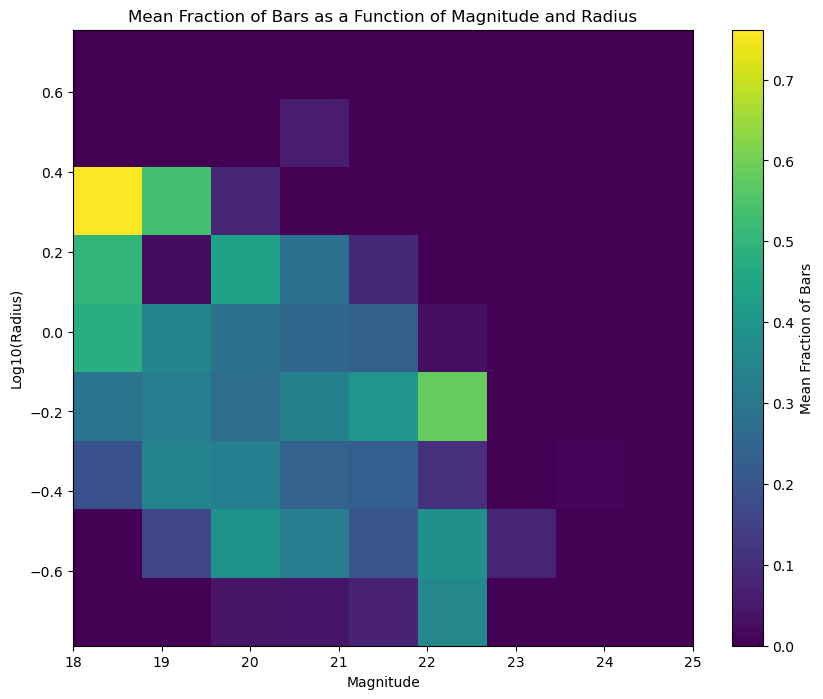

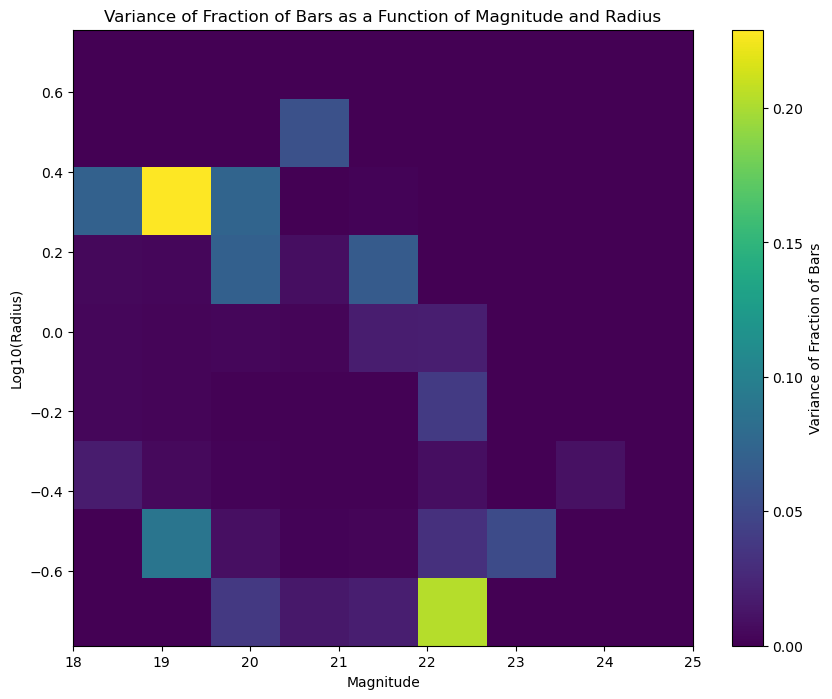

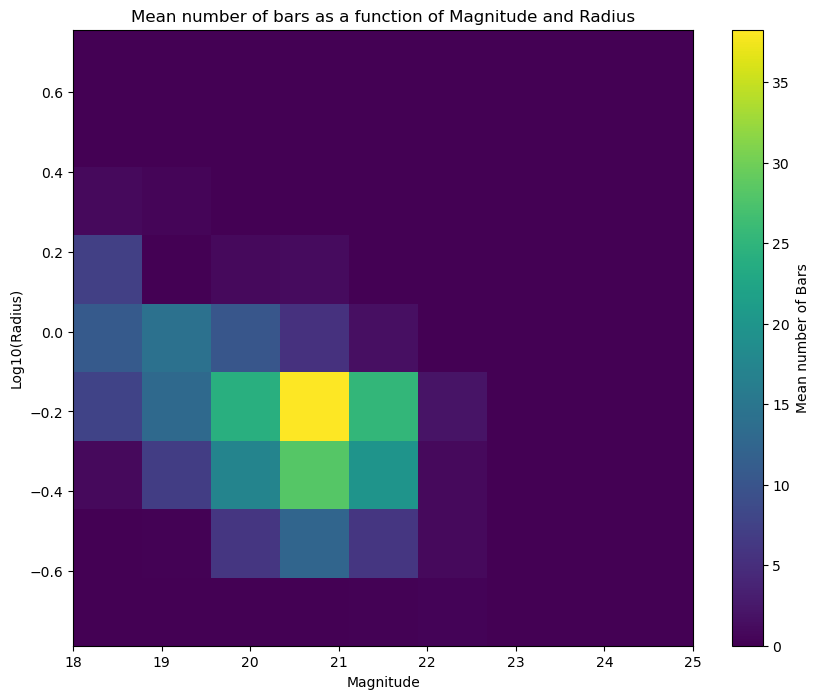

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to clean and convert the string to a numpy array of floats
def clean_and_convert(array_string):
    cleaned_string = array_string.replace('[', '').replace(']', '').replace('\n', ' ')
    return np.fromstring(cleaned_string, sep=' ')

# Apply the function to the columns
#merge['p_bar_samples'] = merge['p_bar_samples'].apply(clean_and_convert)
#merge['p_feature_samples'] = merge['p_feature_samples'].apply(clean_and_convert)
#merge['p_edgeon_samples'] = merge['p_edgeon_samples'].apply(clean_and_convert)

# Calculate the mean of the samples
merge['p_bar_mean'] = merge['p_bar_samples'].apply(np.mean)
merge['p_feature_mean'] = merge['p_feature_samples'].apply(np.mean)

# Select bars and disks for low-z and high-z using the mean values
bars_lz = merge.query('LP_zfinal < 1.5 and LP_mass_med_PDF > 10 and LP_mass_med_PDF < 11 and AXRATIO > 0.5 and p_bar_mean > 0.5 and p_feature_mean > 0.5')
disks_lz = merge.query('LP_zfinal < 1.5 and LP_mass_med_PDF > 10 and LP_mass_med_PDF < 11 and AXRATIO > 0.5 and p_feature_mean > 0.5')

bars_hz = merge.query('LP_zfinal > 3 and LP_zfinal < 6 and LP_mass_med_PDF > 10 and LP_mass_med_PDF < 11 and AXRATIO > 0.5 and p_bar_mean > 0.5 and p_feature_mean > 0.5')
disks_hz = merge.query('LP_zfinal > 3 and LP_zfinal < 6 and LP_mass_med_PDF > 10 and LP_mass_med_PDF < 11 and AXRATIO > 0.5 and p_feature_mean > 0.5')

# Get magnitude and radius values for the histograms
bars_mag = bars_lz.RF_mag.values
bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
disks_mag = disks_lz.RF_mag.values
disks_radius = np.log10(disks_lz.RADIUS.values * 3600)

# Define bin edges
#mag_bins = np.linspace(min(min(bars_mag), min(disks_mag)), max(max(bars_mag), max(disks_mag)), 10)
mag_bins = np.linspace(18, 25, 10)
radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)), 10)

# Initialize arrays to store the histograms for each sample
histograms_bars = np.zeros((100, len(mag_bins) - 1, len(radius_bins) - 1))
histograms_disks = np.zeros((100, len(mag_bins) - 1, len(radius_bins) - 1))
histograms_fbar = np.zeros((100, len(mag_bins) - 1, len(radius_bins) - 1))

# Calculate the histograms for each sample
for i in range(100):
    bars_lz_sample = merge[(merge['LP_zfinal'] > 0) &
                            (merge['LP_zfinal'] < 1) & 
                           (merge['LP_mass_med_PDF'] > 10) & 
                           (merge['LP_mass_med_PDF'] < 11) & 
                           (merge['AXRATIO'] > 0.5) & 
                           (merge['p_edgeon_samples'].apply(lambda x: x[i]) < 0.5) & 
                           (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                           (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
    
    disks_lz_sample = merge[(merge['LP_zfinal'] > 0) &
                            (merge['LP_zfinal'] < 1) & 
                            (merge['LP_mass_med_PDF'] > 10) & 
                            (merge['LP_mass_med_PDF'] < 11) & 
                            (merge['AXRATIO'] > 0.5) & 
                            (merge['p_edgeon_samples'].apply(lambda x: x[i]) < 0.5) & 
                            (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

    bars_hz_sample = merge[(merge['LP_zfinal'] > 3) & 
                           (merge['LP_zfinal'] < 6) & 
                           (merge['LP_mass_med_PDF'] > 10) & 
                           (merge['LP_mass_med_PDF'] < 11) & 
                           (merge['AXRATIO'] > 0.5) & 
                           (merge['p_edgeon_samples'].apply(lambda x: x[i]) < 0.5) & 
                           (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                           (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
    
    disks_hz_sample = merge[(merge['LP_zfinal'] > 3) & 
                            (merge['LP_zfinal'] < 6) & 
                            (merge['LP_mass_med_PDF'] > 10) &
                            (merge['LP_mass_med_PDF'] < 11) & 
                            (merge['p_edgeon_samples'].apply(lambda x: x[i]) < 0.5) & 
                            (merge['AXRATIO'] > 0.5) & 
                            (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

    bars_mag_sample = bars_lz_sample.RF_mag.values
    bars_radius_sample = np.log10(bars_lz_sample.RADIUS.values * 3600)
    disks_mag_sample = disks_lz_sample.RF_mag.values
    disks_radius_sample = np.log10(disks_lz_sample.RADIUS.values * 3600)
    
    histograms_bars[i], _, _ = np.histogram2d(bars_mag_sample, bars_radius_sample, bins=[mag_bins, radius_bins])
    histograms_disks[i], _, _ = np.histogram2d(disks_mag_sample, disks_radius_sample, bins=[mag_bins, radius_bins])
    nonzero_bins = histograms_disks[i] > 0
    (histograms_fbar[i])[nonzero_bins] = (histograms_bars[i])[nonzero_bins]/(histograms_disks[i])[nonzero_bins]

# Calculate the mean and variance of the histograms over the samples
mean_hist_bars = np.mean(histograms_bars, axis=0)
mean_hist_fbar = np.mean(histograms_fbar, axis=0)
var_hist_fbar = np.var(histograms_fbar, axis=0)
#total_hist = mean_hist_bars + mean_hist_disks
#mean_fraction_hist = np.zeros_like(mean_hist_bars)
variance_hist = np.zeros_like(mean_hist_fbar)
poisson_errors = np.zeros_like(mean_hist_fbar)

# Compute the number of objects in each bin of disks_hz
disks_hz_mag = disks_hz.RF_mag.values
disks_hz_radius = np.log10(disks_hz.RADIUS.values * 3600)
disks_hz_hist, _, _ = np.histogram2d(disks_hz_mag, disks_hz_radius, bins=[mag_bins, radius_bins])

nonzero_bins = disks_hz_hist > 0
p  = mean_hist_fbar[nonzero_bins]*disks_hz_hist[nonzero_bins]
#poisson_errors[nonzero_bins] = np.sqrt(p*(1-p)/disks_hz_hist[nonzero_bins])
poisson_errors[nonzero_bins] = np.sqrt(mean_hist_fbar[nonzero_bins] * (1 - mean_hist_fbar[nonzero_bins]) / disks_hz_hist[nonzero_bins])
variance_hist[nonzero_bins] = var_hist_fbar[nonzero_bins] + poisson_errors[nonzero_bins]**2


# Generate 100 samples of the number of expected bars
num_samples = 100
num_bars_samples = np.zeros(num_samples)


for i in range(num_samples):
    
   frac_bars = np.random.normal(loc=mean_hist_fbar, scale=np.sqrt(variance_hist))
   num_bars_samples[i] = np.sum(frac_bars*disks_hz_hist)
   
# Calculate the total number of objects in disks_hz
total_objects = np.sum(disks_hz_hist)

# Calculate the bar fraction for each sample
bar_fractions = num_bars_samples / total_objects

# Compute the mean and variance of the bar fraction
mean_bar_fraction = np.mean(bar_fractions)
variance_bar_fraction = np.sqrt(np.var(bar_fractions))

print(f"Mean bar fraction: {mean_bar_fraction}")
print(f"Sigma of bar fraction: {variance_bar_fraction}")

# Plot the mean fraction histogram
plt.figure(figsize=(10, 8))
plt.imshow(mean_hist_fbar.T, origin='lower', aspect='auto', extent=[mag_bins[0], mag_bins[-1], radius_bins[0], radius_bins[-1]], cmap='viridis')
plt.colorbar(label='Mean Fraction of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Mean Fraction of Bars as a Function of Magnitude and Radius')
plt.show()

# Plot the variance histogram
plt.figure(figsize=(10, 8))
plt.imshow(var_hist_fbar.T, origin='lower', aspect='auto', extent=[mag_bins[0], mag_bins[-1], radius_bins[0], radius_bins[-1]], cmap='viridis',vmin=0)
plt.colorbar(label='Variance of Fraction of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Variance of Fraction of Bars as a Function of Magnitude and Radius')
plt.show()

# Plot the number counts histogram
plt.figure(figsize=(10, 8))
plt.imshow(mean_hist_bars.T, origin='lower', aspect='auto', extent=[mag_bins[0], mag_bins[-1], radius_bins[0], radius_bins[-1]], cmap='viridis',vmin=0)
plt.colorbar(label='Mean number of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Mean number of bars as a function of Magnitude and Radius')
plt.show()


(array([12., 62., 88., 99., 71., 25., 11.,  3.,  2.,  2.]),
 array([-0.65362721, -0.51998715, -0.38634709, -0.25270703, -0.11906697,
         0.01457308,  0.14821314,  0.2818532 ,  0.41549326,  0.54913332,
         0.68277338]),
 <BarContainer object of 10 artists>)

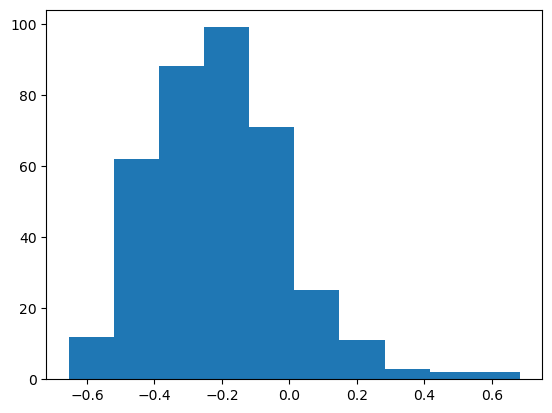

In [71]:
plt.hist(bars_radius_sample)

In [12]:
print(var_hist_fbar.T)

[[0.         0.         0.01098211 0.01280923 0.11706479 0.00354167
  0.002475   0.00593333 0.        ]
 [0.1824     0.01429331 0.00225054 0.00141607 0.00341846 0.00643371
  0.01882614 0.         0.0011    ]
 [0.00775985 0.00337029 0.00064859 0.00060245 0.00199641 0.00231866
  0.01249148 0.         0.012275  ]
 [0.00213501 0.00092885 0.00056184 0.00084104 0.00417598 0.00734767
  0.00941697 0.11714167 0.        ]
 [0.00272397 0.00116987 0.00251883 0.00509122 0.03023203 0.02906875
  0.01556667 0.0651     0.11245208]
 [0.00345256 0.011178   0.01141202 0.03291011 0.015196   0.031275
  0.         0.         0.        ]
 [0.06243333 0.2291     0.01333333 0.0146     0.0475     0.
  0.         0.         0.        ]
 [0.         0.         0.0564     0.0099     0.1271     0.
  0.         0.         0.        ]
 [0.         0.002475   0.         0.         0.         0.
  0.         0.         0.        ]]


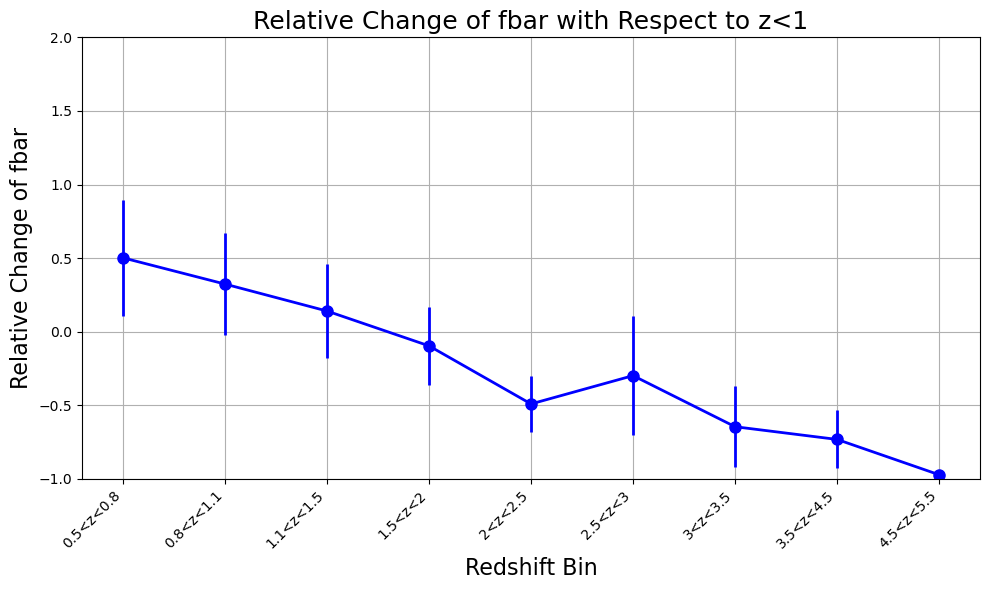

0.5<z<0.8: Mean fbar = 0.2751203971378464, Std. Dev. = 0.02649708922512144
0.8<z<1.1: Mean fbar = 0.24246329759649907, Std. Dev. = 0.023327113843601414
1.1<z<1.5: Mean fbar = 0.20890680153953425, Std. Dev. = 0.027549755154425756
1.5<z<2: Mean fbar = 0.165555609539182, Std. Dev. = 0.02673387464363146
2<z<2.5: Mean fbar = 0.09325817470915736, Std. Dev. = 0.02591824255222064
2.5<z<3: Mean fbar = 0.12848123630778782, Std. Dev. = 0.06735954938346718
3<z<3.5: Mean fbar = 0.06491138826608699, Std. Dev. = 0.0479958618486634
3.5<z<4.5: Mean fbar = 0.0490766625992755, Std. Dev. = 0.0339846601754676
4.5<z<5.5: Mean fbar = 0.0051060551852533855, Std. Dev. = 0.006206432915944742
z<0.8: Mean fbar = 0.18316224925405877, Std. Dev. = 0.04478911656261529


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Ensure the p_bar_samples and p_feature_samples columns are lists/arrays
merge['p_bar_samples'] = merge['p_bar_samples'].apply(lambda x: np.array(x))
merge['p_feature_samples'] = merge['p_feature_samples'].apply(lambda x: np.array(x))
merge['p_edgeon_samples'] = merge['p_edgeon_samples'].apply(lambda x: np.array(x))

# Calculate the mean of the samples
merge['p_bar_mean'] = merge['p_bar_samples'].apply(np.mean)
merge['p_feature_mean'] = merge['p_feature_samples'].apply(np.mean)

# Select bars and disks for low-z using the mean values
bars_lz = merge.query('LP_zfinal > 0 and LP_zfinal < 1 and LP_mass_med_PDF > 10 and LP_mass_med_PDF < 11 and AXRATIO > 0.5 and p_bar_mean > 0.5 and p_feature_mean > 0.5')
disks_lz = merge.query('LP_zfinal > 0 and  LP_zfinal < 1 and LP_mass_med_PDF > 10 and LP_mass_med_PDF < 11 and AXRATIO > 0.5 and p_feature_mean > 0.5')

# Get magnitude and radius values for the histograms
bars_mag = bars_lz.RF_mag.values
bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
disks_mag = disks_lz.RF_mag.values
disks_radius = np.log10(disks_lz.RADIUS.values * 3600)

# Define bin edges
#mag_bins = np.linspace(min(min(bars_mag), min(disks_mag)), max(max(bars_mag), max(disks_mag)), 5)
#radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)),5)

mag_bins = np.linspace(18, 25, 10)
radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)), 10)
# Function to calculate histograms and fractions
def calculate_histograms_and_fractions(merge, z_low, z_high):
    histograms_bars = np.zeros((100, len(mag_bins) - 1, len(radius_bins) - 1))
    histograms_disks = np.zeros((100, len(mag_bins) - 1, len(radius_bins) - 1))
    histograms_fbar = np.zeros((100, len(mag_bins) - 1, len(radius_bins) - 1))
    
    for i in range(100):
        bars_hz_sample = merge[(merge['LP_zfinal'] > z_low) & 
                               (merge['LP_zfinal'] < z_high) & 
                               (merge['LP_mass_med_PDF'] > 10) & 
                               (merge['LP_mass_med_PDF'] < 11) & 
                               (merge['AXRATIO'] > 0.5) & 
                               (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                               (merge['p_edgeon_samples'].apply(lambda x: x[i]) < 0.5) &
                               (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        disks_hz_sample = merge[(merge['LP_zfinal'] > z_low) & 
                                (merge['LP_zfinal'] < z_high) & 
                                (merge['LP_mass_med_PDF'] > 10) &
                                (merge['LP_mass_med_PDF'] < 11) & 
                                (merge['AXRATIO'] > 0.5) & 
                                (merge['p_edgeon_samples'].apply(lambda x: x[i]) < 0.5) &
                                (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        bars_mag_sample = bars_hz_sample.RF_mag.values
        bars_radius_sample = np.log10(bars_hz_sample.RADIUS.values * 3600)
        disks_mag_sample = disks_hz_sample.RF_mag.values
        disks_radius_sample = np.log10(disks_hz_sample.RADIUS.values * 3600)
        
        histograms_bars[i], _, _ = np.histogram2d(bars_mag_sample, bars_radius_sample, bins=[mag_bins, radius_bins])
        histograms_disks[i], _, _ = np.histogram2d(disks_mag_sample, disks_radius_sample, bins=[mag_bins, radius_bins])
        nonzero_bins = histograms_disks[i] > 0
        histograms_fbar[i][nonzero_bins] = histograms_bars[i][nonzero_bins] / histograms_disks[i][nonzero_bins]
    
    # Calculate the mean and variance of the histograms over the samples
    mean_hist_bars = np.mean(histograms_fbar, axis=0)
    var_hist_bars = np.var(histograms_fbar, axis=0)
    
    # Compute the number of objects in each bin of disks_hz
    disks_hz_hist, _, _ = np.histogram2d(disks_mag, disks_radius, bins=[mag_bins, radius_bins])
    
    nonzero_bins = disks_hz_hist > 0
    p = mean_hist_bars[nonzero_bins] * disks_hz_hist[nonzero_bins]
    poisson_errors = np.sqrt(mean_hist_bars[nonzero_bins] * (1 - mean_hist_bars[nonzero_bins]) / disks_hz_hist[nonzero_bins])
    variance_hist = np.zeros_like(var_hist_bars)
    variance_hist[nonzero_bins] = var_hist_bars[nonzero_bins] + poisson_errors**2
    
    # Generate 100 samples of the number of expected bars
    num_samples = 100
    num_bars_samples = np.zeros(num_samples)
    
    for i in range(num_samples):
        frac_bars = np.random.normal(loc=mean_hist_bars, scale=np.sqrt(variance_hist))
        num_bars_samples[i] = np.sum(frac_bars * disks_hz_hist)
    
    # Calculate the total number of objects in disks_hz
    total_objects = np.sum(disks_hz_hist)
    
    # Calculate the bar fraction for each sample
    bar_fractions = num_bars_samples / total_objects
    
    # Compute the mean and variance of the bar fraction
    mean_bar_fraction = np.mean(bar_fractions)
    variance_bar_fraction = np.sqrt(np.var(bar_fractions))
    
    return mean_bar_fraction, variance_bar_fraction

# Redshift bins for high-z
z_bins = [(0.5, 0.8), (0.8, 1.1), (1.1, 1.5), (1.5, 2),(2,2.5),(2.5, 3),(3, 3.5),(3.5,4.5),(4.5,5.5)]
fbar_stats_dict = {}

# Calculate mean_bar_fraction and variance for each redshift bin
for z_low, z_high in z_bins:
    mean_bar_fraction, variance_bar_fraction = calculate_histograms_and_fractions(merge, z_low, z_high)
    fbar_stats_dict[f'{z_low}<z<{z_high}'] = (mean_bar_fraction, variance_bar_fraction)

# Calculate mean_bar_fraction and variance for low-z (z<1)
mean_bar_fraction_lz, variance_bar_fraction_lz = calculate_histograms_and_fractions(merge, 0.2, 0.5)
fbar_stats_dict['z<0.8'] = (mean_bar_fraction_lz, variance_bar_fraction_lz)

# Calculate the relative change of fbar as referred to the point at z<1
relative_changes = []
errors = []
z_bin_labels = []

for z_low, z_high in z_bins:
    mean_fbar_hz, std_fbar_hz = fbar_stats_dict[f'{z_low}<z<{z_high}']
    
    relative_change = (mean_fbar_hz - mean_bar_fraction_lz) / mean_bar_fraction_lz
    error = np.sqrt((std_fbar_hz / mean_bar_fraction_lz) ** 2 + (mean_fbar_hz * variance_bar_fraction_lz / mean_bar_fraction_lz ** 2) ** 2)
    
    relative_changes.append(relative_change)
    errors.append(error)
    z_bin_labels.append(f'{z_low}<z<{z_high}')

# Plot the relative changes with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(z_bin_labels, relative_changes, yerr=errors, fmt='o', linestyle='-', color='blue', linewidth=2, markersize=8)
plt.xlabel('Redshift Bin', fontsize=16)
plt.ylabel('Relative Change of fbar', fontsize=16)
plt.title('Relative Change of fbar with Respect to z<1', fontsize=18)
plt.grid(True)
plt.ylim(-1, 2)  # Adjust y-axis limits as needed
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the fbar statistics dictionary
for key, value in fbar_stats_dict.items():
    print(f"{key}: Mean fbar = {value[0]}, Std. Dev. = {value[1]}")


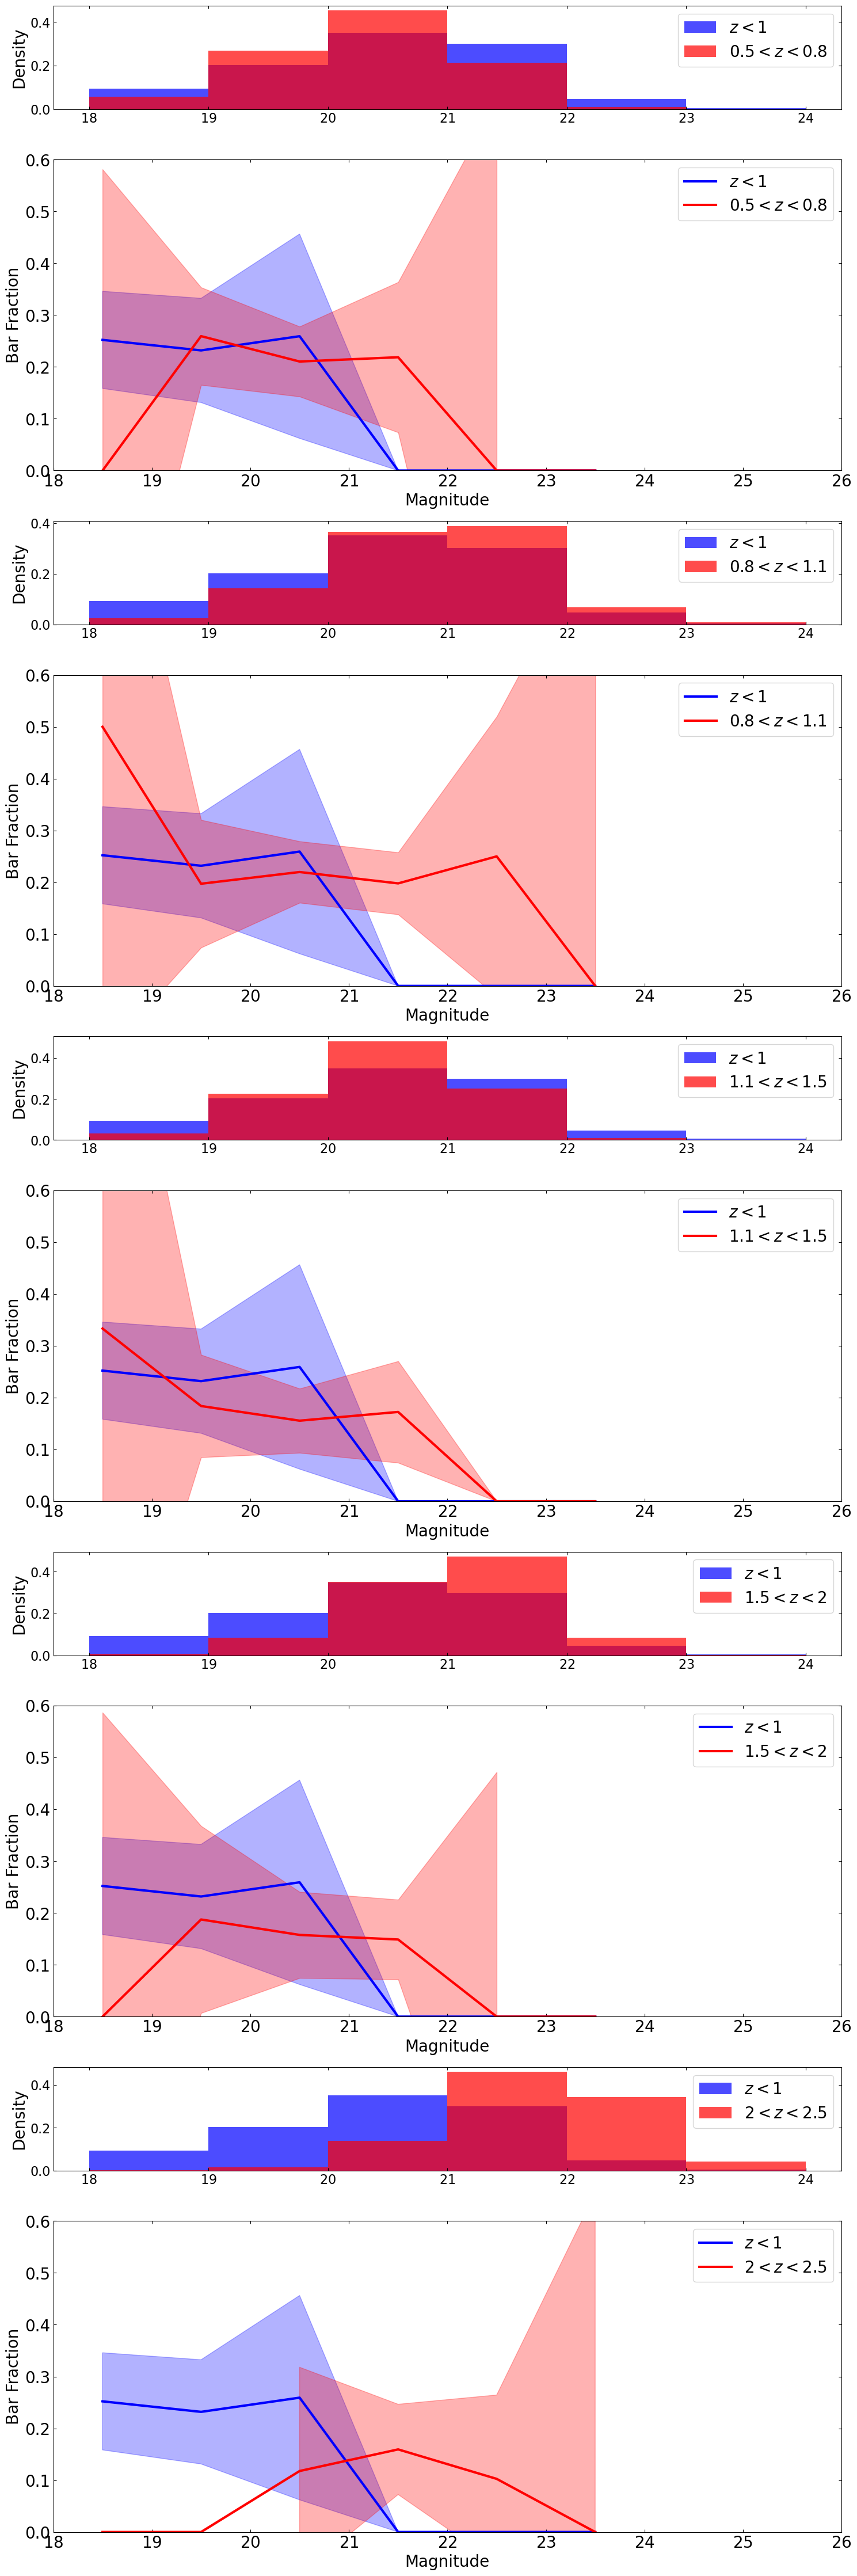

z<1: [0.3317307692307692, 0.3153153153153153, 0.2930232558139535, 0.33497536945812806, 0.33480176211453744, 0.29577464788732394, 0.3211009174311927, 0.3424657534246575, 0.3274336283185841, 0.3238095238095238, 0.3440366972477064, 0.3194444444444444, 0.3412322274881517, 0.33183856502242154, 0.2889908256880734, 0.3257918552036199, 0.31221719457013575, 0.31100478468899523, 0.3146551724137931, 0.3130841121495327, 0.3062200956937799, 0.34513274336283184, 0.2956521739130435, 0.3177570093457944, 0.31981981981981983, 0.2882882882882883, 0.30131004366812225, 0.33980582524271846, 0.3645320197044335, 0.3300970873786408, 0.3492822966507177, 0.3073394495412844, 0.35071090047393366, 0.28703703703703703, 0.34977578475336324, 0.3140096618357488, 0.3125, 0.35714285714285715, 0.35148514851485146, 0.30454545454545456, 0.34234234234234234, 0.33175355450236965, 0.3181818181818182, 0.3209302325581395, 0.3378995433789954, 0.3827751196172249, 0.3039647577092511, 0.29411764705882354, 0.3474178403755869, 0.32653

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

# Ensure the bins are defined
bins = np.arange(18, 25, 1)
bin_centers = (bins[:-1] + bins[1:]) / 2
N_VOLS = 100

# Function to calculate fractions and plot
def calculate_fractions(merge, z_low, z_high):
    fractions_lz = []
    fractions_hz = []
    total_hist_lz = []
    total_hist_hz = []
    fbar_hz = []
    fbar_lz = []

    for i in range(N_VOLS):
        # Apply the conditions manually for each sample
        bars_lz = merge[(merge['LP_zfinal'] > 0.2) &
                        (merge['LP_zfinal'] < .5) & 
                        (merge['LP_mass_med_PDF'] > 10) & 
                        (merge['LP_mass_med_PDF'] < 11) &
                        (merge['AXRATIO'] > 0.5) & 
                        (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                        (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        disks_lz = merge[(merge['LP_zfinal'] > 0.2) & 
                        (merge['LP_zfinal'] < .5) & 
                         (merge['LP_mass_med_PDF'] > 10) & 
                         (merge['LP_mass_med_PDF'] < 11) &
                         (merge['AXRATIO'] > 0.5) & 
                         (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

        bars_hz = merge[(merge['LP_zfinal'] > z_low) & 
                        (merge['LP_zfinal'] < z_high) & 
                        (merge['LP_mass_med_PDF'] > 10) & 
                        (merge['LP_mass_med_PDF'] < 11) & 
                        (merge['AXRATIO'] > 0.5) & 
                        (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                        (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        disks_hz = merge[(merge['LP_zfinal'] > z_low) & 
                         (merge['LP_zfinal'] < z_high) & 
                         (merge['LP_mass_med_PDF'] > 10) & 
                         (merge['LP_mass_med_PDF'] < 11) &
                         (merge['AXRATIO'] > 0.5) & 
                         (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

        if len(disks_hz) > 0:  # Ensure there are disks in this redshift bin
            fbar_hz.append(len(bars_hz) / len(disks_hz))
        if len(disks_lz) > 0:  # Ensure there are disks in low-z bin
            fbar_lz.append(len(bars_lz) / len(disks_lz))

        # Use corresponding magnitude values for disks and bars
        m_disks_lz = disks_lz['RF_mag'].values
        m_bars_lz = bars_lz['RF_mag'].values
        m_disks_hz = disks_hz['RF_mag'].values
        m_bars_hz = bars_hz['RF_mag'].values

        # Calculate histograms for disks and bars in each redshift range
        hist_disks_lz, _ = np.histogram(m_disks_lz, bins=bins)
        hist_bars_lz, _ = np.histogram(m_bars_lz, bins=bins)
        hist_disks_hz, _ = np.histogram(m_disks_hz, bins=bins)
        hist_bars_hz, _ = np.histogram(m_bars_hz, bins=bins)

        # Calculate the fraction of bars
        total_lz = hist_disks_lz + hist_bars_lz
        fraction_bars_lz = np.divide(hist_bars_lz, total_lz, out=np.zeros_like(hist_bars_lz, dtype=float), where=total_lz != 0)
        total_hz = hist_disks_hz + hist_bars_hz
        fraction_bars_hz = np.divide(hist_bars_hz, total_hz, out=np.zeros_like(hist_bars_hz, dtype=float), where=total_hz != 0)

        fractions_lz.append(fraction_bars_lz)
        fractions_hz.append(fraction_bars_hz)
        total_hist_lz.append(total_lz)
        total_hist_hz.append(total_hz)

    fractions_lz = np.array(fractions_lz)
    fractions_hz = np.array(fractions_hz)
    total_hist_lz = np.array(total_hist_lz)
    total_hist_hz = np.array(total_hist_hz)

    # Compute median and 1-sigma scatter for low-z and high-z
    median_fraction_lz = np.nanmedian(fractions_lz, axis=0)
    lower_bound_lz = np.nanpercentile(fractions_lz, 16, axis=0)
    upper_bound_lz = np.nanpercentile(fractions_lz, 84, axis=0)

    median_fraction_hz = np.nanmedian(fractions_hz, axis=0)
    lower_bound_hz = np.nanpercentile(fractions_hz, 16, axis=0)
    upper_bound_hz = np.nanpercentile(fractions_hz, 84, axis=0)

    # Calculate Poisson errors for the histograms
    poisson_errors_lz = np.sqrt(np.nanmedian(total_hist_lz, axis=0))
    poisson_errors_hz = np.sqrt(np.nanmedian(total_hist_hz, axis=0))

    # Combine errors in quadrature
    combined_errors_lz = np.sqrt((upper_bound_lz - median_fraction_lz) ** 2 + (poisson_errors_lz / total_hist_lz.mean(axis=0)) ** 2)
    combined_errors_hz = np.sqrt((upper_bound_hz - median_fraction_hz) ** 2 + (poisson_errors_hz / total_hist_hz.mean(axis=0)) ** 2)

    return {
        'median_fraction_lz': median_fraction_lz,
        'lower_bound_lz': lower_bound_lz,
        'upper_bound_lz': upper_bound_lz,
        'combined_errors_lz': combined_errors_lz,
        'median_fraction_hz': median_fraction_hz,
        'lower_bound_hz': lower_bound_hz,
        'upper_bound_hz': upper_bound_hz,
        'combined_errors_hz': combined_errors_hz,
        'total_hist_hz': total_hist_hz
    }, fbar_lz, fbar_hz

# Redshift bins for high-z
z_bins = [(0.5, 0.8), (0.8, 1.1), (1.1, 1.5), (1.5, 2),(2,2.5),(2.5, 3),(3, 3.5),(3.5,4.5),(4.5,5.5)]
colors = ['red', 'red', 'red', 'red', 'red']
fbar_dict = {}

# Calculate fractions and errors for z<1
results_lz, fbar_lz, _ = calculate_fractions(merge, 0, 1)
fbar_dict['z<1'] = fbar_lz

# Create figure and specify grid layout
fig = plt.figure(figsize=(15, 80))
gs = GridSpec(2 * len(z_bins), 1, height_ratios=[1, 3] * len(z_bins), figure=fig)

# Plot for each redshift bin
for idx, ((z_low, z_high), color) in enumerate(zip(z_bins, colors)):
    ax_histx = fig.add_subplot(gs[2 * idx])
    ax_main = fig.add_subplot(gs[2 * idx + 1])

    # Calculate fractions and errors for high-z bin
    results_hz, _, fbar_hz = calculate_fractions(merge, z_low, z_high)
    fbar_dict[f'{z_low}<z<{z_high}'] = fbar_hz

    # Plot histograms in the upper subpanel
    ax_histx.hist(merge.query('LP_zfinal<1 and LP_zfinal>0 and AXRATIO>0.5 and LP_mass_med_PDF>10')['RF_mag'].values, 
                  bins=bins, label='$z<1$', color='blue', alpha=0.7, density=True)
    ax_histx.hist(merge.query(f'LP_zfinal>{z_low} and LP_zfinal<{z_high} and AXRATIO>0.5 and LP_mass_med_PDF>10')['RF_mag'].values, 
                  bins=bins, label=f'${z_low}<z<{z_high}$', color=color, alpha=0.7, density=True)

    ax_histx.legend(loc='upper right', fontsize=20)
   
    ax_histx.set_ylabel('Density', fontsize=20)
    ax_histx.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
    ax_histx.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    # Plot low-z data in the main panel
    ax_main.plot(bin_centers, results_lz['median_fraction_lz'], linestyle='-', linewidth=3, label='$z<1$', color='blue')
    ax_main.fill_between(bin_centers, results_lz['median_fraction_lz'] - results_lz['combined_errors_lz'],
                         results_lz['median_fraction_lz'] + results_lz['combined_errors_lz'], color='blue', alpha=0.3)

    # Plot high-z data in the main panel
    ax_main.plot(bin_centers, results_hz['median_fraction_hz'], linestyle='-', linewidth=3, label=f'${z_low}<z<{z_high}$', color=color)
    ax_main.fill_between(bin_centers, results_hz['median_fraction_hz'] - results_hz['combined_errors_hz'],
                         results_hz['median_fraction_hz'] + results_hz['combined_errors_hz'], color=color, alpha=0.3)

    # Set labels and limits for the main panel
    ax_main.set_xlim([18, 26])
    ax_main.set_ylim([0, .6])
    ax_main.set_xlabel('Magnitude', fontsize=20)
    ax_main.set_ylabel('Bar Fraction', fontsize=20)
    ax_main.legend(fontsize=20)
    ax_main.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
    ax_main.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax_main.set_aspect('auto')

plt.tight_layout()
plt.show()

# fbar_dict now contains the fbar_hz and fbar_lz values for each redshift bin
for key, value in fbar_dict.items():
    print(f"{key}: {value}")


(array([ 4.,  5., 20., 22., 21., 18.,  9.,  3.,  2.,  1.]),
 array([20.704193 , 21.0474818, 21.3907706, 21.7340594, 22.0773482,
        22.420637 , 22.7639258, 23.1072146, 23.4505034, 23.7937922,
        24.137081 ]),
 <BarContainer object of 10 artists>)

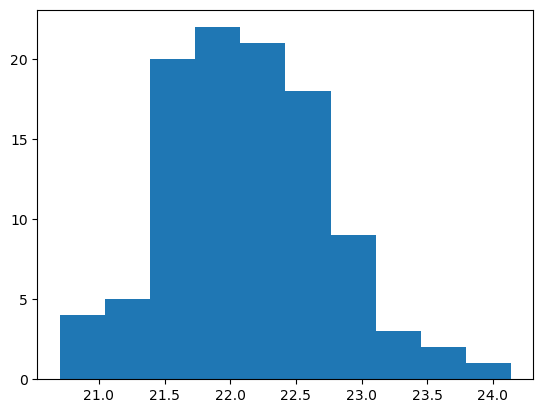

In [50]:
plt.hist(disks_hz.MAG_MODEL_F150W)

In [55]:
disks_hz = merge[(merge['LP_zfinal'] > 2) & 
                         (merge['LP_zfinal'] < 3) & 
                         (merge['LP_mass_med_PDF'] > 10) & 
                         (merge['LP_mass_med_PDF'] < 11)] 

In [60]:
disks_lz = merge[(merge['LP_zfinal'] < 1) & 
                         (merge['LP_zfinal'] < 1) & 
                         (merge['LP_mass_med_PDF'] > 10) & 
                         (merge['LP_mass_med_PDF'] < 11)]

(array([1.100e+01, 1.000e+00, 1.000e+00, 3.500e+01, 1.990e+02, 1.330e+03,
        4.520e+03, 2.707e+03, 1.226e+03, 5.320e+02]),
 array([ 9.117292 , 10.9053978, 12.6935036, 14.4816094, 16.2697152,
        18.057821 , 19.8459268, 21.6340326, 23.4221384, 25.2102442,
        26.99835  ]),
 <BarContainer object of 10 artists>)

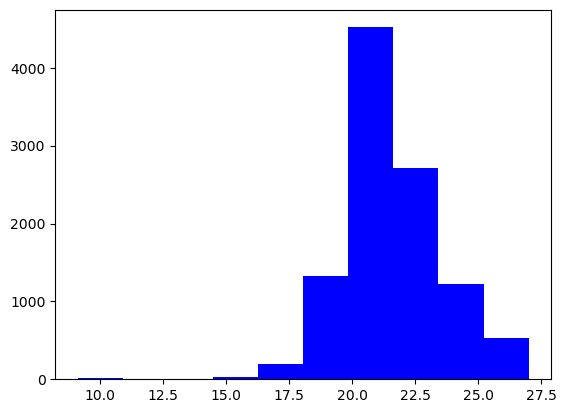

In [62]:
plt.hist(disks_hz.MAG_MODEL_F150W,color='red')
plt.hist(disks_lz.MAG_MODEL_F150W,color='blue')

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

# Ensure the bins are defined
bins = np.arange(20, 28, 1)
bin_centers = (bins[:-1] + bins[1:]) / 2
N_VOLS = 100

# Function to calculate fractions and plot
def calculate_fractions(merge, z_low, z_high):
    
    fbar_hz = []
    fbar_lz = []

    for i in range(N_VOLS):
        # Apply the conditions manually for each sample
        bars_lz = merge[(merge['LP_zfinal'] > 0.2) &
                        (merge['LP_zfinal'] < .5) & 
                        (merge['LP_mass_med_PDF'] > 10) & 
                        (merge['LP_mass_med_PDF'] < 11) &
                        (merge['AXRATIO'] > 0.5) & 
                        (merge['p_edgeon_samples'].apply(lambda x: x[i]) < 0.5) & 
                        (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                        (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        disks_lz = merge[(merge['LP_zfinal'] > 0.2) &
                        (merge['LP_zfinal'] < .5) & 
                         (merge['LP_mass_med_PDF'] > 10) & 
                         (merge['LP_mass_med_PDF'] < 11) &
                         (merge['AXRATIO'] > 0.5) & 
                         (merge['p_edgeon_samples'].apply(lambda x: x[i]) < 0.5) &
                         (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

        bars_hz = merge[(merge['LP_zfinal'] > z_low) & 
                        (merge['LP_zfinal'] < z_high) & 
                        (merge['LP_mass_med_PDF'] > 10) & 
                        (merge['LP_mass_med_PDF'] < 11) & 
                        (merge['AXRATIO'] > 0.5) & 
                        (merge['p_edgeon_samples'].apply(lambda x: x[i]) < 0.5) &
                        (merge['p_bar_samples'].apply(lambda x: x[i]) > 0.5) & 
                        (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]
        
        disks_hz = merge[(merge['LP_zfinal'] > z_low) & 
                         (merge['LP_zfinal'] < z_high) & 
                         (merge['LP_mass_med_PDF'] > 10) & 
                         (merge['LP_mass_med_PDF'] < 11) &
                         (merge['AXRATIO'] > 0.5) & 
                         (merge['p_edgeon_samples'].apply(lambda x: x[i]) < 0.5) &
                         (merge['p_feature_samples'].apply(lambda x: x[i]) > 0.5)]

        if len(disks_hz) > 0:  # Ensure there are disks in this redshift bin
            fbar_hz.append(len(bars_hz) / len(disks_hz))
        if len(disks_lz) > 0:  # Ensure there are disks in low-z bin
            fbar_lz.append(len(bars_lz) / len(disks_lz))

    return fbar_lz, fbar_hz



# Redshift bins for high-z
#z_bins =  [0.2,0.5,0.8,1.1,1.5,2,2.5,3,3.5,4.5,5.5]
z_bins = [(0.5, 0.8), (0.8, 1.1), (1.1, 1.5), (1.5, 2),(2,2.5),(2.5, 3),(3, 3.5),(3.5,4.5),(4.5,5.5)]
colors = ['red', 'red', 'red', 'red', 'red']
fbar_dict = {}

# Calculate fractions and errors for z<1
fbar_lz, _ = calculate_fractions(merge, 0.2, 0.5)
fbar_dict['z<1'] = fbar_lz

for idx, ((z_low, z_high)) in enumerate(z_bins):
    
    # Calculate fractions and errors for high-z bin
    fbar_lz , fbar_hz = calculate_fractions(merge, z_low, z_high)
    fbar_dict[f'{z_low}<z<{z_high}'] = fbar_hz

   




12
0.2


(array([ 2.,  4.,  4., 19., 20., 17., 12., 11.,  8.,  3.]),
 array([0.03846154, 0.06108597, 0.08371041, 0.10633484, 0.12895928,
        0.15158371, 0.17420814, 0.19683258, 0.21945701, 0.24208145,
        0.26470588]),
 <BarContainer object of 10 artists>)

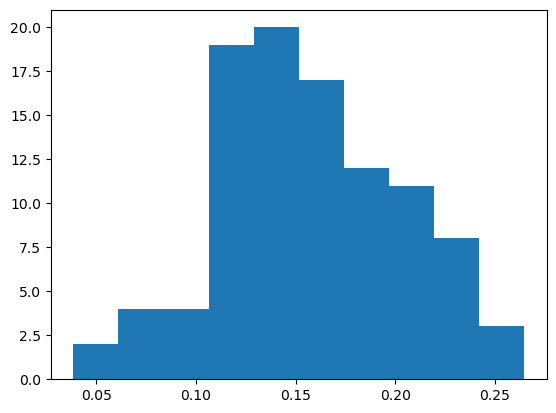

In [38]:
print(len(bars_hz))
print(np.median(fbar_dict['5<z<6']))
plt.hist(fbar_dict['4<z<5'])

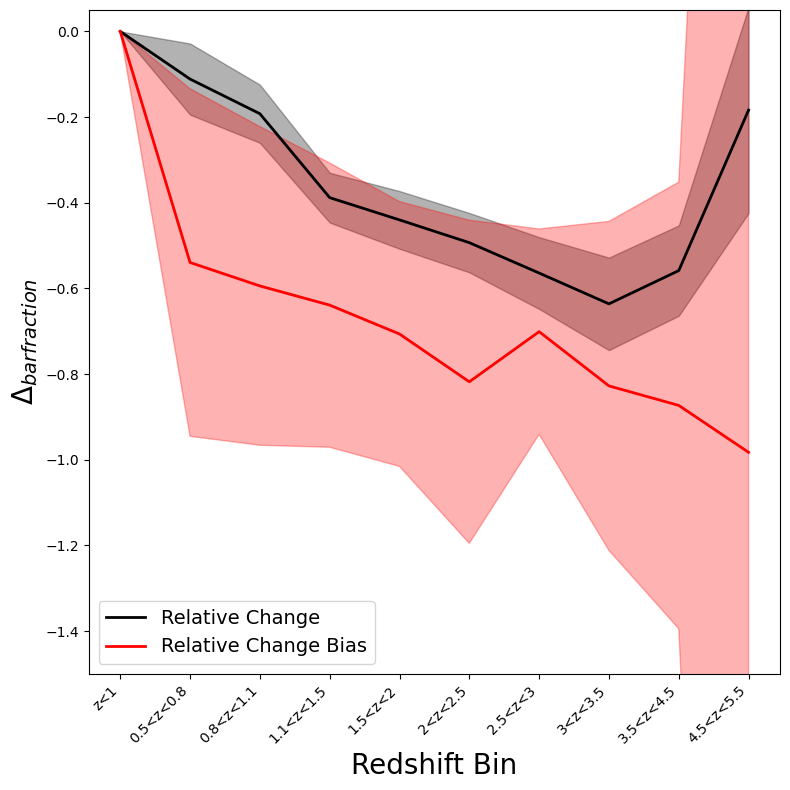

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from astropy.stats import sigma_clip

# Function to calculate mean and variance of fbar
def calculate_fbar_stats(fbar_list):
    # Perform sigma clipping
    clipped_data = sigma_clip(fbar_list, sigma=3)  # Adjust sigma value as needed

     
    #clipped_mean = np.mean(clipped_data.data[~clipped_data.mask])
    mean_fbar = np.mean(clipped_data.data[~clipped_data.mask])
    variance_fbar = np.var(clipped_data.data[~clipped_data.mask])
    return mean_fbar, np.sqrt(variance_fbar)

# Calculate fbar stats for z<1
mean_fbar_lz, std_fbar_lz = calculate_fbar_stats(fbar_dict['z<1'])

# Calculate fbar stats for each redshift bin and compute relative change
relative_changes = []
errors = []
relative_changes_bias = []
errors_bias = []
z_bin_labels = []

z_bin_labels.append(f'z<1')
relative_changes.append(0.0)
errors.append(0.0)

relative_changes_bias.append(0.0)
errors_bias.append(0.0)

for (z_low, z_high) in [(0.5, 0.8), (0.8, 1.1), (1.1, 1.5), (1.5, 2),(2,2.5),(2.5, 3),(3, 3.5),(3.5,4.5),(4.5,5.5)]:
    fbar_hz = fbar_dict[f'{z_low}<z<{z_high}']
    fbar_bias = fbar_stats_dict[f'{z_low}<z<{z_high}']
    mean_fbar_hz, std_fbar_hz = calculate_fbar_stats(fbar_hz)
    mean_fbar_bias, std_fbar_bias = calculate_fbar_stats(fbar_bias)
    
    relative_change = (mean_fbar_hz - mean_fbar_lz) / mean_fbar_lz
    error = np.sqrt((std_fbar_hz / mean_fbar_lz) ** 2 + (mean_fbar_hz * std_fbar_lz / mean_fbar_lz ** 2) ** 2)

    relative_change_bias = (mean_fbar_bias - mean_fbar_lz) / mean_fbar_lz
    error_bias = np.sqrt((std_fbar_bias / mean_fbar_lz) ** 2 + (mean_fbar_bias * std_fbar_lz / mean_fbar_bias ** 2) ** 2)
    
    relative_changes.append(relative_change)
    errors.append(error)

    relative_changes_bias.append(relative_change_bias)
    errors_bias.append(error_bias)
    z_bin_labels.append(f'{z_low}<z<{z_high}')

# Plot the relative changes with shaded regions
plt.figure(figsize=(8, 8))
plt.plot(z_bin_labels, relative_changes, color='black', linewidth=2, markersize=8, label='Relative Change')
plt.fill_between(z_bin_labels, np.array(relative_changes) - np.array(errors), np.array(relative_changes) + np.array(errors), color='black', alpha=0.3)

plt.plot(z_bin_labels, relative_changes_bias, color='red', linewidth=2, markersize=8, label='Relative Change Bias')
plt.fill_between(z_bin_labels, np.array(relative_changes_bias) - np.array(errors_bias), np.array(relative_changes_bias) + np.array(errors_bias), color='red', alpha=0.3)

plt.xlabel('Redshift Bin', fontsize=20)
plt.ylabel('$\Delta_{bar fraction}$', fontsize=20)
plt.grid(False)
plt.ylim(-1.5, 0.05)  # Adjust y-axis limits as needed
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower left', fontsize=14)
plt.tight_layout()
plt.show()


In [86]:
print(relative_changes)

[0.0, -0.3369963245771283, -0.4650344146862492, -0.5431932793655082, -0.4696610803573815, -0.32713042168366013]


In [84]:
print(fbar_dict['5<z<6'])

[0.2, 0.25, 0.125, 0.2857142857142857, 0.1111111111111111, 0.14285714285714285, 0.1111111111111111, 0.14285714285714285, 0.1, 0.25, 0.125, 0.42857142857142855, 0.125, 0.2222222222222222, 0.125, 0.25, 0.5, 0.1111111111111111, 0.1111111111111111, 0.1, 0.14285714285714285, 0.2, 0.14285714285714285, 0.16666666666666666, 0.14285714285714285, 0.2857142857142857, 0.16666666666666666, 0.16666666666666666, 0.125, 0.3333333333333333, 0.07692307692307693, 0.1111111111111111, 0.2, 0.14285714285714285, 0.3333333333333333, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.1111111111111111, 0.3333333333333333, 0.1, 0.125, 0.16666666666666666, 0.2222222222222222, 0.5, 0.2, 0.25, 0.2, 0.5, 0.1, 0.2, 0.2222222222222222, 0.15384615384615385, 0.1111111111111111, 0.2857142857142857, 0.16666666666666666, 0.14285714285714285, 0.2, 0.3333333333333333, 0.1, 0.2222222222222222, 0.08333333333333333, 0.1, 0.1, 0.25, 0.2, 0.3333333333333333, 0.3333333333333333, 0.125, 0.25, 0.3333333333333333, 0.111111